In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils import (load_config, seed_everything, calculate_cv_per_class, calculate_d_ratio, calculate_detection_rate, correct_blank,
                       get_low_cv_features, get_high_detection_rate_features, get_high_mz_features)

In [2]:
# for reproducibility
seed_everything(42)

# config file
config = load_config("../configs/config.yaml")

# Set Seaborn style
sns.set(style=config['sns_params']['style'],
        palette=config['sns_params']['palette'],
        font_scale=config['sns_params']['font_scale'])

# Set Matplotlib parameters
plt.rcParams.update(config['plt_params'])

### Read files 

In [3]:
sample_meta = pd.read_csv(config['paths']['sample_meta_path'])
sample_meta = sample_meta[sample_meta['batch']==1]

data_mat = pd.read_csv(config['paths']['data_mat_path'])
data_mat = data_mat[data_mat['sample'].isin(sample_meta['sample'].values.tolist())]

feat_meta = pd.read_csv(config['paths']['feat_meta_path'])

ft_columns = [col for col in data_mat.columns if col.startswith('FT')]
bio_ids = sample_meta[sample_meta['class'].isin(['LMU', 'French', 'Dunn'])]['sample'].values.tolist()
ss_ids = sample_meta[sample_meta['class'].isin(['SS'])]['sample'].values.tolist()

### Correct blanks

In [4]:
# This step subtracts the mean intensity of Blank samples from Bio and QC samples
data_mat[ft_columns] = correct_blank(
    data_mat[ft_columns], sample_meta, sample_classes=['LMU', 'French', 'Dunn', 'QC', 'dQC'], blank_classes=['B']
)

/Users/saadat/Desktop/ml_iso/glycan_analysis/task1/src/utils.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_matrix.loc[samples_meta['class'].isin(sample_classes)] = corrected


### Filters

In [5]:
# filter 1: CV < 0.3 in QC samples
low_cv_features = get_low_cv_features(data_mat, sample_meta, ft_columns, threshold=0.3)
len(low_cv_features)


192

In [6]:
# filter 2: detection rate >= 0.7 in bio samples
high_detection_rate_features = get_high_detection_rate_features(data_mat, sample_meta, ft_columns, bio_samples=['LMU', 'French', 'Dunn'], threshold=0.7)
len(high_detection_rate_features)

252

In [7]:
# filter 3: mz > 500
features_in_mass_range = get_high_mz_features(feat_meta, mz_threshold=500)
len(features_in_mass_range)

248

In [8]:
# apply all filters
pass_features = list(set(low_cv_features) & set(high_detection_rate_features) & set(features_in_mass_range))
len(pass_features)

189

In [9]:
# update data_mat and feat_meta
data_mat = data_mat[['sample'] + pass_features]
feat_meta = feat_meta[feat_meta['feature'].isin(pass_features)]

### Check intensities for exogenous standards

In [10]:
# based on EDA, we know the IDs of exogenous compounds
exog_feat = ['FT-005', 'FT-010', 'FT-162', 'FT-169']
data_mat_cp = data_mat[data_mat['sample'].isin(bio_ids)].copy()

# samples that are not within 3 std of mean for exog. compounds are removed
n_std = 3
outliers = data_mat_cp[exog_feat].apply(lambda x: ((x - x.mean()).abs() / x.std()) > n_std) 
rows_with_true = outliers.any(axis=1)
samples_to_remove = [bio_ids[i] for i in rows_with_true[rows_with_true].index]
print(f'samples to remove are: {samples_to_remove}')

# update data_mat and samples_meta
data_mat = data_mat[~data_mat['sample'].isin(samples_to_remove)]
sample_meta = sample_meta[~sample_meta['sample'].isin(samples_to_remove)]

samples to remove are: ['20241106-297-Dunn-20']


### Checking sample-to-sample variation

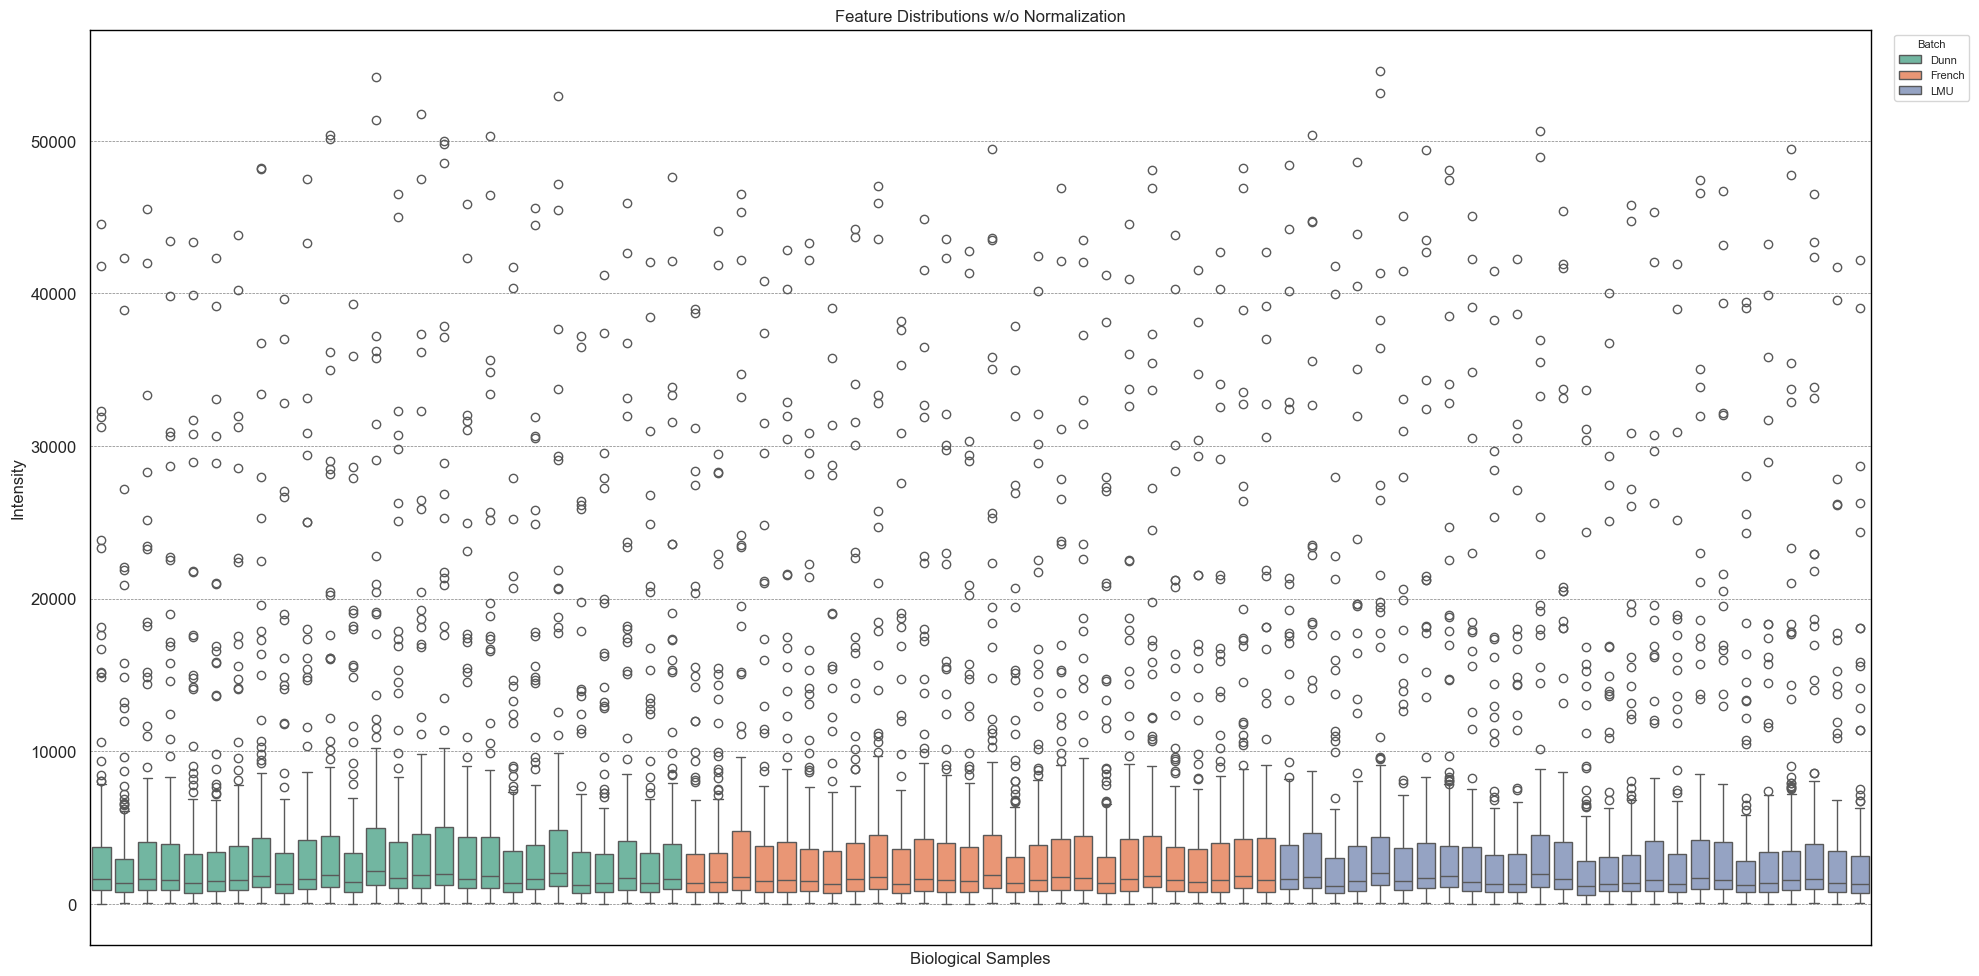

In [11]:
# Melt data_matrix for class-level analysis
intensity_long = data_mat.melt(id_vars='sample', var_name='feature', value_name='intensity')

# Merge with acquisition_list to add class labels
intensity_long = intensity_long.merge(sample_meta[['sample', 'class']], on='sample')
intensity_long_bio = intensity_long[intensity_long['class'].isin(['French', 'LMU', 'Dunn'])]

plt.figure(figsize=(20, 10))
sns.boxplot(data=intensity_long_bio, x='sample', y='intensity', hue='class', palette = 'Set2')
plt.title('Feature Distributions w/o Normalization')
plt.xlabel('Biological Samples')
plt.ylabel('Intensity')
plt.xticks(None)
plt.legend(title='Batch', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks([])  
plt.tight_layout()
plt.savefig(f"{config['paths']['figures_dir']}/feature_dist_noNorm.png")
plt.show()

In [12]:
# normalize by total intensity
data_mat[pass_features] = data_mat[pass_features].divide(data_mat[pass_features].sum(axis=1), axis=0)

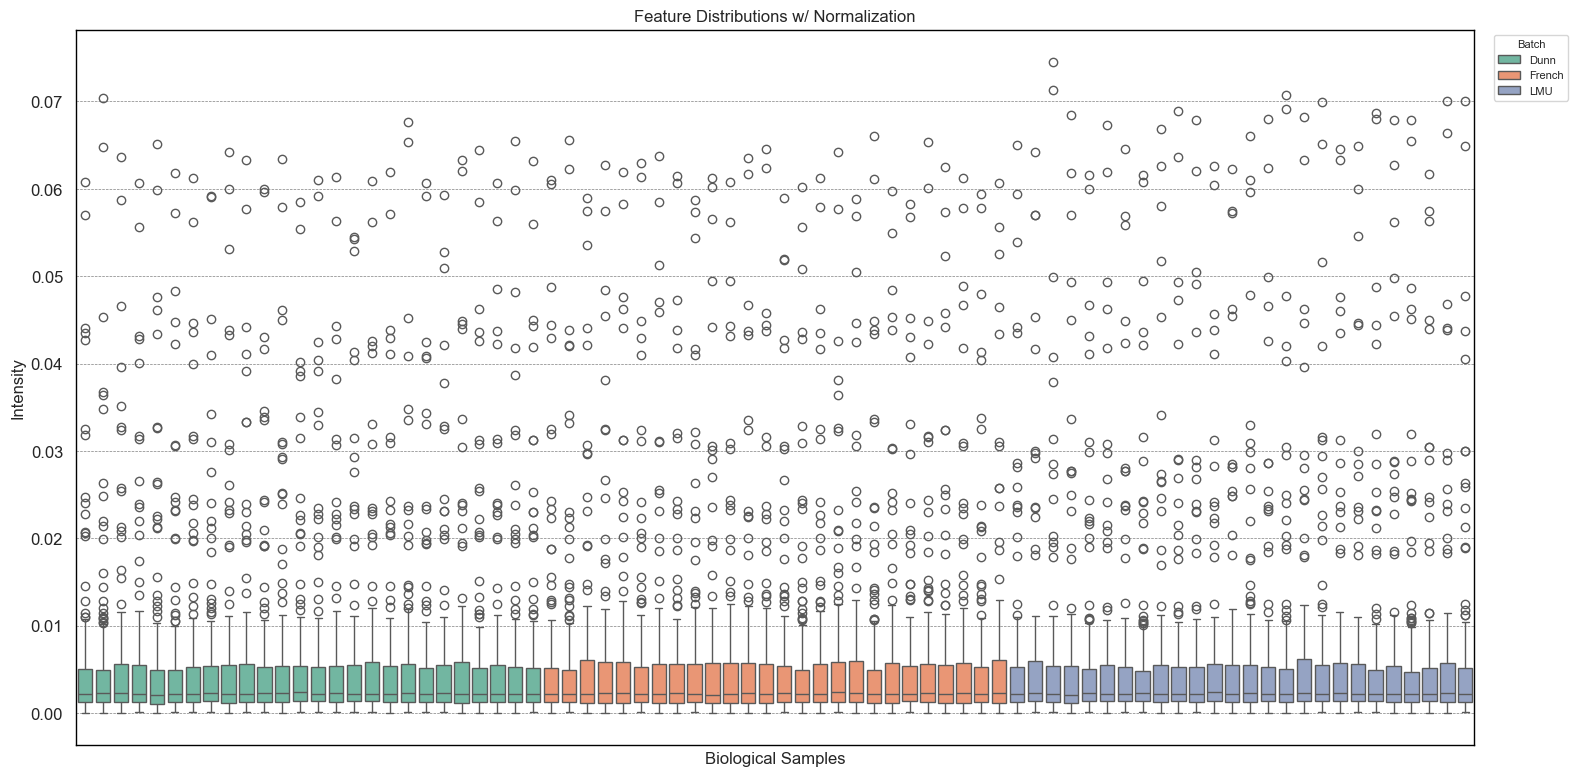

In [13]:

# Melt data_matrix for class-level analysis
intensity_long = data_mat.melt(id_vars='sample', var_name='feature', value_name='intensity')

# Merge with acquisition_list to add class labels
intensity_long = intensity_long.merge(sample_meta[['sample', 'class']], on='sample')
intensity_long_bio = intensity_long[intensity_long['class'].isin(['French', 'LMU', 'Dunn'])]

plt.figure(figsize=(16, 8))
sns.boxplot(data=intensity_long_bio, x='sample', y='intensity', hue='class', palette = 'Set2')
plt.title('Feature Distributions w/ Normalization')
plt.xlabel('Biological Samples')
plt.ylabel('Intensity')
plt.xticks(None)
plt.legend(title='Batch', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks([])  
plt.tight_layout()
plt.savefig(f"{config['paths']['figures_dir']}/feature_dist_withNorm.png")
plt.show()


In [14]:
data_mat_final = data_mat[data_mat['sample'].isin(bio_ids)].merge(sample_meta[['sample', 'class']], how='left')
print(f'number of selected features {data_mat_final.shape[1] - 2} \n number of selected samples {data_mat_final.shape[0]}')
data_mat_final.to_csv('../results/misc/data_mat_filter_norm.csv', index=False)

number of selected features 189 
 number of selected samples 78
